## ETF分群、分析比較  
以下用ETF_data_crawler中爬取下來的資料作進一步資料清洗跟繪圖  
初步想法 :  
> 繪圖  
* 四年來平均交易量  
* 平均報酬率  

> 分群  
* 平均交易量  
* 價格高、中、低  
* 波動幅度大、小  
* 價格變化趨勢異、同  


在繪圖比較前，將 ETF_historical_data 中的資料作進一步計算(ex.平均值)以及格式轉換  
檢查欲分析的dataframe

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xlwt
import xlrd
df = pd.read_excel('ETF_historical_data.xls')
df.head()

,Symbol0,Date0,Close0,Open0,High0,Low0,Volumn0,Change0,Symbol1,Date1,...,Volumn23,Change23,Symbol24,Date24,Close24,Open24,High24,Low24,Volumn24,Change24
0,QQQ,2015年1月,101.10,103.76,104.58,99.36,826.29M,-2.08%,XLK,2015年1月,...,1.30M,-0.95%,TECL,2015年1月,31.02,35.51,35.70,30.43,8.14M,-10.86%
1,NaN,2015年2月,108.40,101.33,108.94,99.75,472.46M,7.22%,NaN,2015年2月,...,729.31K,6.00%,NaN,2015年2月,38.82,30.93,39.44,29.74,5.27M,25.15%
2,NaN,2015年3月,105.60,108.61,109.42,104.24,633.64M,-2.58%,NaN,2015年3月,...,398.59K,-0.33%,NaN,2015年3月,34.77,38.82,39.83,33.42,6.59M,-10.43%
3,NaN,2015年4月,107.63,105.60,111.16,104.34,568.70M,1.92%,NaN,2015年4月,...,550.96K,3.06%,NaN,2015年4月,37.43,34.78,40.05,33.65,5.42M,7.65%
4,NaN,2015年5月,110.05,108.05,111.08,106.00,518.23M,2.25%,NaN,2015年5月,...,334.66K,0.95%,NaN,2015年5月,39.30,37.73,40.46,35.46,4.45M,5.00%


建立一個檔案存取要視覺化的資料，從篩選後ETF資料複製Symbol列，寫入新檔案第1列

In [2]:
target_etf = xlrd.open_workbook('sel_etf_tech.xls')
sh = target_etf.sheet_by_name("Sheet1")

d = xlwt.Workbook() #create new file
sheet = d.add_sheet(u'sheet',cell_overwrite_ok=True) #create sheet
data = [sh.cell_value(row,1) for row in range(sh.nrows)]

for index, value in enumerate(data):
    sheet.write(index, 0, value)

* 平均交易量
Volumn列的值不是float，為了計算平均值要將代表千(K)、百萬(M)、十億(B)的單位符號去掉，換成實際數值

In [3]:
sheet.write(0, 1, 'Avg_vol') # Average Trading Volume
sheet.write(0, 2, 'Avg_cpri') # Average Close Price

etf_data1 = pd.read_excel('ETF_historical_data.xls', sheet_name = 'sheet1')
etf_data2 = pd.read_excel('ETF_historical_data.xls', sheet_name = 'sheet2')

for n in range(2):
    #pd.read_excel('ETF_historical_data.xls', sheet_name = 'sheet'+str(n+1))
    #etf_data = etf_data.fillna(" ")
    for i in range(25):
        #etf_data['Volumn'+str(i)] = etf_data['Volumn'+str(i)].drop([0,0])
        if n == 0:
            vol = etf_data1['Volumn'+str(i)]
            cpri = etf_data1['Close'+str(i)]
        elif n == 1 and i != 24:
            vol = etf_data2['Volumn'+str(i+25)]
            cpri = etf_data2['Close'+str(i+25)]
        elif n == 1 and i == 24:
            break
            
        # K:k=1, M:k=1000, B:k=1000000 將符號換成要乘上的倍數
        k = vol.str.extract(r'[\d\.]+([KMB]+)', expand=False).fillna(1).replace(['K','M','B'], [1, 10**3, 10**6]).astype(int)
        vol = (vol.replace(r'[KMB]', '', regex=True).astype(float))*k
        
        mv = vol.mean() # mean volumn
        mc = cpri.mean()
        if n == 0:
            sheet.write(i+1, 1, mv)
            sheet.write(i+1, 2, mc)
        if n == 1:
            sheet.write(i+26, 1, mv)
            sheet.write(i+26, 2, mc)
            
d.save('ETF_data_plot.xls')

將各個ETF從2015-2019年的平均交易量畫成長條圖

<BarContainer object of 49 artists>

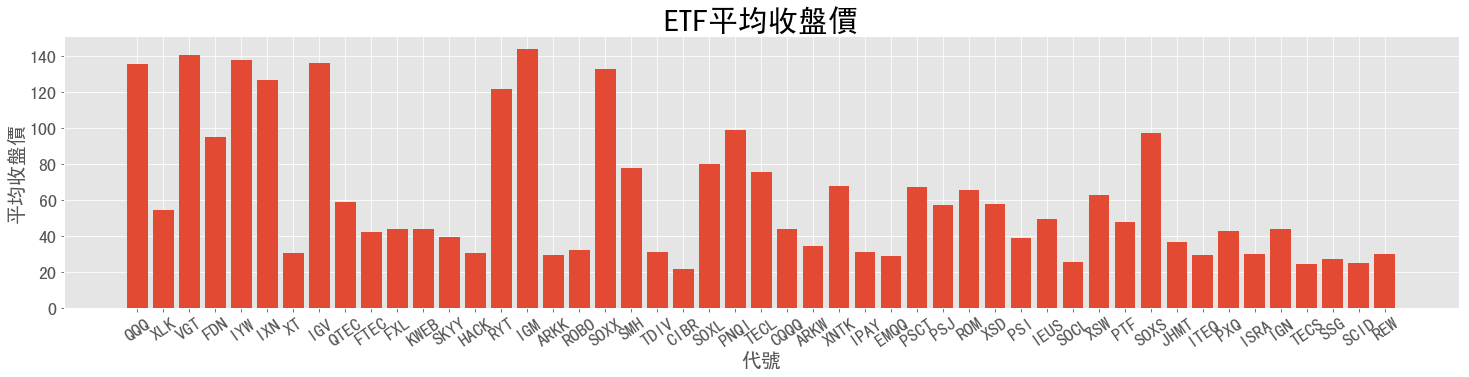

In [4]:
plt.style.use('ggplot') #set the style of the picture
plt.rcParams['font.sans-serif'] = ['simhei'] #set chinese word font

avg_data = pd.read_excel("ETF_data_plot.xls")

plt.figure(figsize=(25, 5))
plt.title('ETF平均收盤價',fontsize=30) # set title
# set label
plt.xlabel('代號',fontsize=20)
plt.ylabel('平均收盤價',fontsize=20)
# set ticks(so that they don't overlap)
plt.xticks(fontsize=18,rotation=35)
plt.yticks(fontsize=18)
plt.bar(avg_data['Symbol'], avg_data['Avg_cpri']) # plot
#plt.pie(avg_vol['Avg_vol'],labels = avg_vol['Symbol'])

各ETF平均收盤價並不一致，整體大致在20~150之間，若以價格高低切分，可得數目還算平均之高、中、低三類。

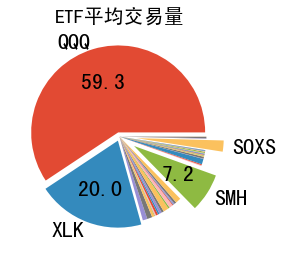

In [5]:
plt.figure() 
plt.title('ETF平均交易量',fontsize=20) # set title

show_lab = []
explode = []
hot_etf = []

for i in range(len(avg_data['Avg_vol'])):
    if 200000 > avg_data['Avg_vol'][i] > 20000:
        show_lab.append(avg_data['Symbol'][i])
        explode.append(0.2)
        hot_etf.append(avg_data['Symbol'][i]) #get etf which has large mean volumn
    elif avg_data['Avg_vol'][i] >= 20000:
        show_lab.append(avg_data['Symbol'][i])
        explode.append(0.05)
        hot_etf.append(avg_data['Symbol'][i])
    else:
        show_lab.append('')
        explode.append(0.0)

def show_autopct(pct):
    return ('%.1f' % pct) if pct > 5 else ''  

plt.rcParams['font.size'] = 22
plt.pie(avg_data['Avg_vol'], explode = explode, labels=show_lab, autopct=show_autopct)

plt.show()

同為科技類股，ETF之間的平均交易量顯然有懸殊差別，圓餅圖可以看出相對比例，由平均交易量可推測居首位的QQQ是熱門ETF，而其也確實為美國排名十大ETF之一，第二名的XLK就大約僅有其1/3的交易量，落差顯著  
(雖然ETF通常包括非常多個股，但同樣類型的ETF卻沒有因為股票成分類似而受到較"平均"的消費者喜愛?)

直覺上由於科技業產品生命週期短，連動性強，交易量前幾名的ETF可能會有相似的價格波動趨勢，以下畫出剛剛找到的前四個ETF(hot_etf)收盤價走勢觀察。

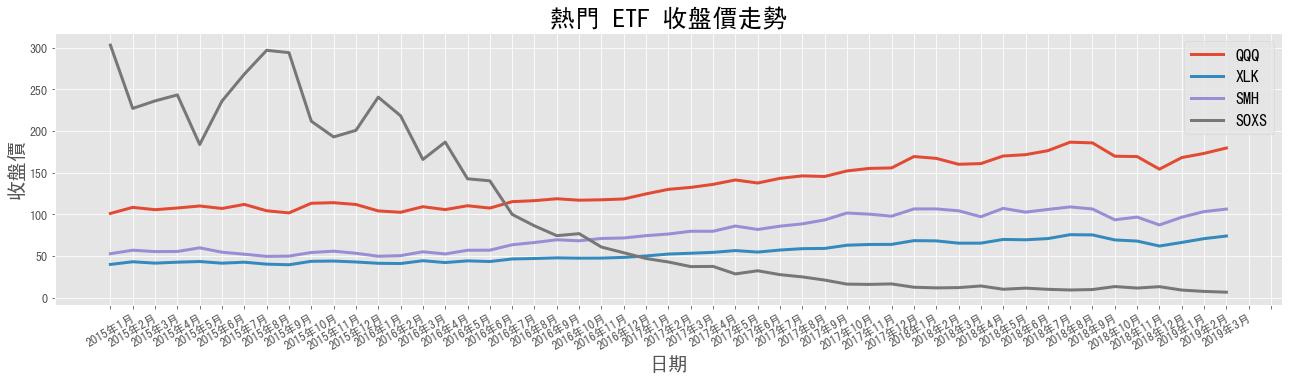

In [40]:
plt.figure(figsize=(22, 5)) #plot a new one
plt.title('熱門 ETF 收盤價走勢',fontsize=25) #set title
#set label
plt.xlabel('日期',fontsize=20)
plt.ylabel('收盤價',fontsize=20)
    
#set xticks interval so they won't overlap
plt.xticks(rotation=30)
ax = plt.gca()
plt.xticks(np.arange(55), etf_data1['Date0'])

def plot(sym,data):
    
    #deal with the missing data 
    data = data[~data.isin(["0"])] #get the data if it != "0"
    
    plt.rcParams['font.size'] = 12
    
    #plot the line chart
    plt.plot(etf_data1['Date0'], data, lw = 3)

h = 0 
for i in range(2):  # sheet1 sheet2
    for j in range(25): # 24 etf in each sheet
        if h == len(hot_etf): # find all the hot_etf already 
            break
        if i == 0:  #sheet1 
            if hot_etf[h] in etf_data1['Symbol'+str(j)][0]:
                plot(etf_data1['Symbol'+str(j)][0],  etf_data1['Close'+str(j)])
                #print(etf_data1['Symbol'+str(j)][0],  etf_data1['Close'+str(j)])
                h += 1
        elif i == 1 and j != 24: #sheet2
            if hot_etf[h] in etf_data2['Symbol'+str(j+25)][0]:
                plot(etf_data2['Symbol'+str(j+25)][0],  etf_data2['Close'+str(j+25)])
                h += 1
        elif i == 1 and j == 24:
            break
plt.legend(labels=hot_etf, fontsize=16)

前三名ETF還可以說收盤價曲線相似，然而soxs(每日三倍放空半導體)完全成相反走勢。  
推測可能科技類股ETF其實波動幅度很大，各股票價格變化也不盡相同  
亦有可能僅為巧合(4個樣本不明顯)，須進一步分群探討

參考網站  
[簡單預測股價](https://www.finlab.tw/%E8%B6%85%E7%B0%A1%E5%96%AE-Machine-Learning-%E9%A0%90%E6%B8%AC%E8%82%A1%E5%83%B9/)  
[簡單選股回測](https://www.finlab.tw/Python-%E7%B0%A1%E5%96%AE%E9%81%B8%E8%82%A1%E5%92%8C%E5%9B%9E%E6%B8%AC/)  
[panda選股回測](https://www.finlab.tw/%E5%88%A9%E7%94%A8Pandas%E8%BC%95%E9%AC%86%E5%8F%96%E5%BE%97%E6%AD%B7%E5%8F%B2%E8%82%A1%E5%83%B9/)  
[panda數據處理](https://blog.csdn.net/A632189007/article/details/76176985)  
[matplotlib圓餅圖標籤顯示問題](https://stackoverflow.com/questions/34035427/conditional-removal-of-labels-in-matplotlib-pie-chart/34035864  )